# **1. 데이터 및 라이브러리 불러오기**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import json
import os
import tqdm

from konlpy.tag import Okt

import sklearn
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import log_loss, accuracy_score,f1_score
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from transformers import *

In [ ]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
sample_submission=pd.read_csv('sample_submission.csv')

# **2. 데이터 EDA**

In [ ]:
train.head(2)

,index,제출년도,사업명,사업_부처명,계속과제여부,내역사업명,과제명,요약문_연구목표,요약문_연구내용,요약문_기대효과,요약문_한글키워드,요약문_영문키워드,label
0,0,2016,농업기초기반연구,농촌진흥청,신규,농산물안전성연구,유전정보를 활용한 새로운 해충 분류군 동정기술 개발,○ 새로운 해충분류군의 동정기술 개발 및 유입확산 추적,(가) 외래 및 돌발해충의 발생조사 및 종 동정\n\n\n ○ 대상해충 : 최...,"○ 새로운 돌발 및 외래해충의 신속, 정확한 동정법 향상\n\n\n○ 돌발 및 외래...","뉴클레오티드 염기서열, 분자마커, 종 동정, 침샘, 전사체","nucleotide sequence, molecular marker, species...",24
1,1,2019,이공학학술연구기반구축(R&D),교육부,신규,지역대학우수과학자지원사업(1년~5년),대장암의 TRAIL 내성 표적 인자 발굴 및 TRAIL 반응 예측 유전자 지도 구축...,최종목표: TRAIL 감수성 표적 유전자를 발굴하고 내성제어 기전을 연구. 발굴된...,1차년도\n1) Microarray를 통한 선천적 TRAIL 내성 표적 후보 유전자...,"1) TRAIL 내성 특이적 표적분자를 발굴하고, 이를 이용한 TRAIL 효과 증진...","대장암,항암제 내성,세포사멸,유전자발굴","TRAIL,Colorectal cancer,TRAIL resistance,Apopt...",0


In [ ]:
test.head(2)

,index,제출년도,사업명,사업_부처명,계속과제여부,내역사업명,과제명,요약문_연구목표,요약문_연구내용,요약문_기대효과,요약문_한글키워드,요약문_영문키워드
0,174304,2016,경제협력권산업육성,산업통상자원부,신규,자동차융합부품,R-FSSW 기술 적용 경량 차체 부품 개발 및 품질 평가를 위한 64채널 C-SC...,○ 차체 점용접부의 품질 검사를 위한 64채널 무선 기반 C-Scan 탐촉자 개발\...,○ 1차년도\n\n . 개발 탐촉 시스템의 성능 평가 위한 표준 시편 제작 시...,○ 기술적 파급효과\n\n - 본 연구에서 개발된 R-FSSW 접합 기술은 기존 ...,"마찰교반점용접, 비파괴 검사, 초음파 탐상, 씨 스캔, 용접 품질 평가","Friction Stir Spot Welding, Non-destructive ev..."
1,174305,2018,개인기초연구(과기정통부)(R&D),과학기술정보통신부,계속,신진연구(총연구비5천이상~1.5억이하),다입자계를 묘사하는 편미분방정식에 대한 연구,자연계에는 입자의 개수가 아주 큰 다양한 다입자계가 존재한다. 이런 다입자계의 효...,연구과제1. 무한입자계의 동역학 / 작용소(operator) 방정식에 대한 연구\n...,본 연구는 물리학에서 중요한 대상인 다입자계를 묘사하는 모델방정식의 정당성을 보장하...,"다체계 방정식,동역학의 안정성,양자역학,고전역학,평균장 극한,고전극한,비상대론적 극한","many particle system,stability of dynamics,qua..."


In [ ]:
sample_submission.head(6)

,index,label
0,174304,0
1,174305,0
2,174306,0
3,174307,0
4,174308,0
5,174309,0


In [ ]:
train.columns

Index(['index', '제출년도', '사업명', '사업_부처명', '계속과제여부', '내역사업명', '과제명', '요약문_연구목표',
       '요약문_연구내용', '요약문_기대효과', '요약문_한글키워드', '요약문_영문키워드', 'label'],
      dtype='object')

In [ ]:
test.columns

Index(['index', '제출년도', '사업명', '사업_부처명', '계속과제여부', '내역사업명', '과제명', '요약문_연구목표',
       '요약문_연구내용', '요약문_기대효과', '요약문_한글키워드', '요약문_영문키워드'],
      dtype='object')

In [ ]:
#데이터 구조 파악
print(train.shape)
print(test.shape)
print(sample_submission.shape)

(174304, 13)
(43576, 12)
(43576, 2)


In [ ]:
#심각한 불균형 데이터임을 알 수 있습니다.
train.label.value_counts(sort=False)/len(train)

0     0.817945
1     0.007234
2     0.001578
3     0.000820
4     0.000327
5     0.009742
6     0.000447
7     0.000648
8     0.001945
9     0.000608
10    0.003775
11    0.001147
12    0.001538
13    0.003299
14    0.009592
15    0.000947
16    0.002903
17    0.000884
18    0.008893
19    0.028330
20    0.006076
21    0.002846
22    0.000849
23    0.010556
24    0.020195
25    0.004647
26    0.001813
27    0.003557
28    0.002576
29    0.005898
30    0.001342
31    0.005290
32    0.001492
33    0.003058
34    0.003001
35    0.001669
36    0.006081
37    0.001526
38    0.001503
39    0.001159
40    0.002530
41    0.000384
42    0.000293
43    0.002014
44    0.000522
45    0.006523
Name: label, dtype: float64

과제명 길이 최댓값: 229
과제명 길이 최솟값: 2
과제명 길이 평균값: 35.84252225995961
과제명 길이 중간값: 34.0


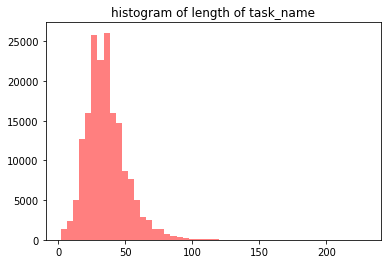

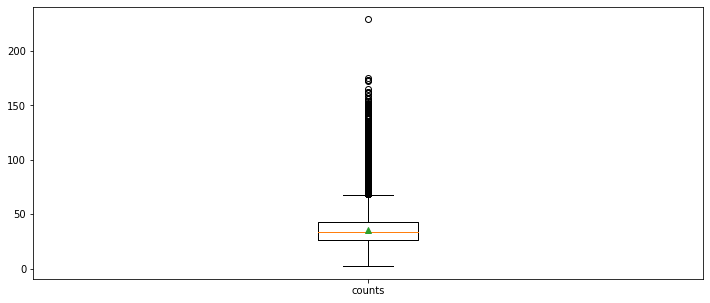

In [ ]:
length=train['과제명'].astype(str).apply(len)
plt.hist(length, bins=50, alpha=0.5, color='r', label='word')
plt.title('histogram of length of task_name')
plt.figure(figsize=(12, 5))
plt.boxplot(length, labels=['counts'], showmeans=True)
print('과제명 길이 최댓값: {}'.format(np.max(length)))
print('과제명 길이 최솟값: {}'.format(np.min(length)))
print('과제명 길이 평균값: {}'.format(np.mean(length)))
print('과제명 길이 중간값: {}'.format(np.median(length)))

요약문_연구목표 길이 최댓값: 3951
요약문_연구목표 길이 최솟값: 1
요약문_연구목표 길이 평균값: 318.1008066366807
요약문_연구목표 길이 중간값: 249.0


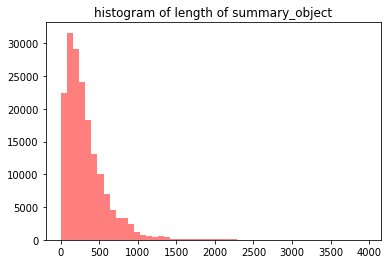

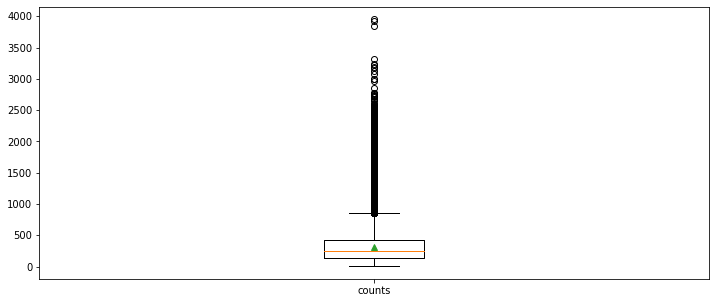

In [ ]:
length=train['요약문_연구목표'].astype(str).apply(len)
plt.hist(length, bins=50, alpha=0.5, color='r', label='word')
plt.title('histogram of length of summary_object')
plt.figure(figsize=(12, 5))
plt.boxplot(length, labels=['counts'], showmeans=True)
print('요약문_연구목표 길이 최댓값: {}'.format(np.max(length)))
print('요약문_연구목표 길이 최솟값: {}'.format(np.min(length)))
print('요약문_연구목표 길이 평균값: {}'.format(np.mean(length)))
print('요약문_연구목표 길이 중간값: {}'.format(np.median(length)))

요약문_연구내용 길이 최댓값: 3999
요약문_연구내용 길이 최솟값: 1
요약문_연구내용 길이 평균값: 699.2930282724435
요약문_연구내용 길이 중간값: 597.0


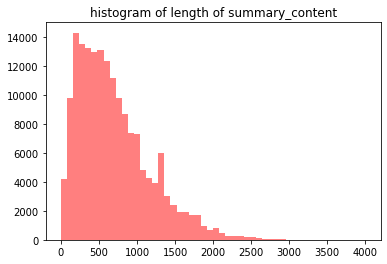

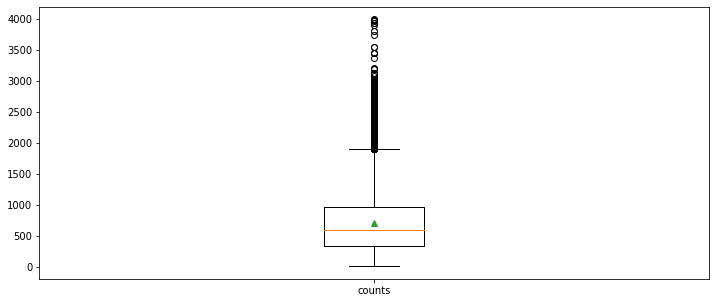

In [ ]:
length=train['요약문_연구내용'].astype(str).apply(len)
plt.hist(length, bins=50, alpha=0.5, color='r', label='word')
plt.title('histogram of length of summary_content')
plt.figure(figsize=(12, 5))
plt.boxplot(length, labels=['counts'], showmeans=True)
print('요약문_연구내용 길이 최댓값: {}'.format(np.max(length)))
print('요약문_연구내용 길이 최솟값: {}'.format(np.min(length)))
print('요약문_연구내용 길이 평균값: {}'.format(np.mean(length)))
print('요약문_연구내용 길이 중간값: {}'.format(np.median(length)))

요약문_기대효과 길이 최댓값: 3649
요약문_기대효과 길이 최솟값: 1
요약문_기대효과 길이 평균값: 400.4864374885258
요약문_기대효과 길이 중간값: 329.0


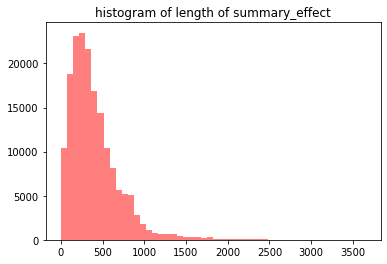

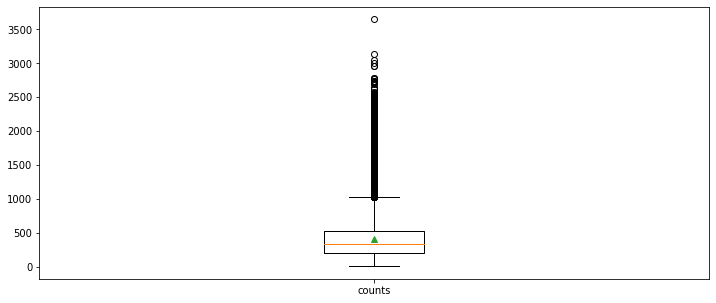

In [ ]:
length=train['요약문_기대효과'].astype(str).apply(len)
plt.hist(length, bins=50, alpha=0.5, color='r', label='word')
plt.title('histogram of length of summary_effect')
plt.figure(figsize=(12, 5))
plt.boxplot(length, labels=['counts'], showmeans=True)
print('요약문_기대효과 길이 최댓값: {}'.format(np.max(length)))
print('요약문_기대효과 길이 최솟값: {}'.format(np.min(length)))
print('요약문_기대효과 길이 평균값: {}'.format(np.mean(length)))
print('요약문_기대효과 길이 중간값: {}'.format(np.median(length)))

# **LSTM**

### 데이터 전처리

In [ ]:
#해당 baseline 에서는 과제명 columns만 활용했습니다.
#다채로운 변수 활용법으로 성능을 높여주세요!
train=train[['과제명','label']]
test=test[['과제명']]

In [ ]:
train.head(2)

,과제명,label
0,유전정보를 활용한 새로운 해충 분류군 동정기술 개발,24
1,대장암의 TRAIL 내성 표적 인자 발굴 및 TRAIL 반응 예측 유전자 지도 구축...,0


In [ ]:
test.head(2)

,과제명
0,R-FSSW 기술 적용 경량 차체 부품 개발 및 품질 평가를 위한 64채널 C-SC...
1,다입자계를 묘사하는 편미분방정식에 대한 연구


In [ ]:
#1. re.sub 한글 및 공백을 제외한 문자 제거
#2. okt 객체를 활용해 형태소 단위로 나눔
#3. remove_stopwords로 불용어 제거 
def preprocessing(text, okt, remove_stopwords=False, stop_words=[]):
    text=re.sub("[^가-힣ㄱ-ㅎㅏ-ㅣ]","", text)
    word_text=okt.morphs(text, stem=True)
    if remove_stopwords:
        word_review=[token for token in word_text if not token in stop_words]
    return word_review

In [ ]:
stop_words=['은','는','이','가', '하','아','것','들','의','있','되','수','보','주','등','한']
okt=Okt()
clean_train_text=[]
clean_test_text=[]

In [ ]:
#시간이 많이 걸립니다.
for text in tqdm.tqdm(train['과제명']):
    try:
        clean_train_text.append(preprocessing(text, okt, remove_stopwords=True, stop_words=stop_words))
    except:
        clean_train_text.append([])
    

100%|██████████| 174304/174304 [57:37<00:00, 50.41it/s] 


In [ ]:
for text in tqdm.tqdm(test['과제명']):
    if type(text) == str:
        clean_test_text.append(preprocessing(text, okt, remove_stopwords=True, stop_words=stop_words))
    else:
        clean_test_text.append([])

100%|██████████| 43576/43576 [15:29<00:00, 46.89it/s]


In [ ]:
print(len(clean_train_text))
print(len(clean_test_text))

174304
43576


In [ ]:
#텐서플로의 전처리 모듈을 활용해 토크나이징 객체를 만든 후 인덱스 벡터로 전환
tokenizer=Tokenizer()
tokenizer.fit_on_texts(clean_train_text)

train_sequences=tokenizer.texts_to_sequences(clean_train_text)
test_sequences=tokenizer.texts_to_sequences(clean_test_text)
word_vocab=tokenizer.word_index

#패딩 처리
train_inputs=pad_sequences(train_sequences, maxlen=40, padding='post')
test_inputs=pad_sequences(test_sequences, maxlen=40, padding='post')

In [ ]:
print(train_inputs.shape)
print(test_inputs.shape)

(174304, 40)
(43576, 40)


In [ ]:
labels=np.array(train['label'])
len(set(labels))

46

In [ ]:
#추후 재사용 가능하도록 npy로 전환
DATA_IN_PATH='./data_in/'
TRAIN_INPUT_DATA = 'train_input.npy'
TEST_INPUT_DATA = 'test_input.npy'

import os
if not os.path.exists(DATA_IN_PATH):
    os.makedirs(DATA_IN_PATH)
    
np.save(open(DATA_IN_PATH+TRAIN_INPUT_DATA, 'wb'), train_inputs)
np.save(open(DATA_IN_PATH+TEST_INPUT_DATA, 'wb'), test_inputs)

data_configs={}
data_configs['vocab']=word_vocab
data_configs['vocab_size'] = len(word_vocab)+1
json.dump(data_configs, open(DATA_IN_PATH+'data_configs.json', 'w'), ensure_ascii=False)

### 모델링

In [ ]:
#파라미터 설정
vocab_size =data_configs['vocab_size']
embedding_dim = 32
max_length = 40
oov_tok = "<OOV>"

In [ ]:
#가벼운 NLP모델 생성
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(46, activation='softmax')
])

# compile model
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# model summary
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 40, 32)            973376    
_________________________________________________________________
global_average_pooling1d_1 ( (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               4224      
_________________________________________________________________
dense_3 (Dense)              (None, 46)                5934      
Total params: 983,534
Trainable params: 983,534
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
# fit model
num_epochs = 30
history = model.fit(train_inputs, labels, 
                    epochs=num_epochs, verbose=2, 
                    validation_split=0.2)

Epoch 1/30
4358/4358 - 28s - loss: 0.9296 - accuracy: 0.8202 - val_loss: 0.8065 - val_accuracy: 0.8248
Epoch 2/30
4358/4358 - 24s - loss: 0.6618 - accuracy: 0.8400 - val_loss: 0.6244 - val_accuracy: 0.8463
Epoch 3/30
4358/4358 - 25s - loss: 0.5196 - accuracy: 0.8643 - val_loss: 0.5572 - val_accuracy: 0.8582
Epoch 4/30
4358/4358 - 24s - loss: 0.4356 - accuracy: 0.8810 - val_loss: 0.5206 - val_accuracy: 0.8663
Epoch 5/30
4358/4358 - 25s - loss: 0.3740 - accuracy: 0.8946 - val_loss: 0.4925 - val_accuracy: 0.8742
Epoch 6/30
4358/4358 - 25s - loss: 0.3273 - accuracy: 0.9061 - val_loss: 0.4862 - val_accuracy: 0.8788
Epoch 7/30
4358/4358 - 24s - loss: 0.2925 - accuracy: 0.9148 - val_loss: 0.4805 - val_accuracy: 0.8818
Epoch 8/30
4358/4358 - 25s - loss: 0.2648 - accuracy: 0.9218 - val_loss: 0.4684 - val_accuracy: 0.8866
Epoch 9/30
4358/4358 - 24s - loss: 0.2407 - accuracy: 0.9283 - val_loss: 0.4734 - val_accuracy: 0.8909
Epoch 10/30
4358/4358 - 25s - loss: 0.2210 - accuracy: 0.9341 - val_loss:

# **Random Forest**

### 데이터 전처리

In [ ]:
#해당 baseline 에서는 과제명 columns만 활용했습니다.
#다채로운 변수 활용법으로 성능을 높여주세요!
train=train[['과제명','label']]
test=test[['과제명']]

In [ ]:
train.head(2)

,과제명,label
0,유전정보를 활용한 새로운 해충 분류군 동정기술 개발,24
1,대장암의 TRAIL 내성 표적 인자 발굴 및 TRAIL 반응 예측 유전자 지도 구축...,0


In [ ]:
test.head(2)

,과제명
0,R-FSSW 기술 적용 경량 차체 부품 개발 및 품질 평가를 위한 64채널 C-SC...
1,다입자계를 묘사하는 편미분방정식에 대한 연구


In [ ]:
#1. re.sub 한글 및 공백을 제외한 문자 제거
#2. okt 객체를 활용해 형태소 단위로 나눔
#3. remove_stopwords로 불용어 제거 
def preprocessing(text, okt, remove_stopwords=False, stop_words=[]):
    text=re.sub("[^가-힣ㄱ-ㅎㅏ-ㅣ]","", text)
    word_text=okt.morphs(text, stem=True)
    if remove_stopwords:
        word_review=[token for token in word_text if not token in stop_words]
    return word_review

In [ ]:
stop_words=['은','는','이','가', '하','아','것','들','의','있','되','수','보','주','등','한']
okt=Okt()
clean_train_text=[]
clean_test_text=[]

In [ ]:
#시간이 많이 걸립니다.
for text in tqdm.tqdm(train['과제명']):
    try:
        clean_train_text.append(preprocessing(text, okt, remove_stopwords=True, stop_words=stop_words))
    except:
        clean_train_text.append([])
    

100%|██████████| 174304/174304 [44:25<00:00, 65.39it/s]


In [ ]:
for text in tqdm.tqdm(test['과제명']):
    if type(text) == str:
        clean_test_text.append(preprocessing(text, okt, remove_stopwords=True, stop_words=stop_words))
    else:
        clean_test_text.append([])

100%|██████████| 43576/43576 [12:25<00:00, 58.44it/s]


In [ ]:
len(clean_train_text)

174304

In [ ]:
len(clean_test_text)

43576

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

#tokenizer 인자에는 list를 받아서 그대로 내보내는 함수를 넣어줍니다. 또한 소문자화를 하지 않도록 설정해야 에러가 나지 않습니다.
vectorizer = CountVectorizer(tokenizer = lambda x: x, lowercase=False)
train_features=vectorizer.fit_transform(clean_train_text)
test_features=vectorizer.transform(clean_test_text)
#test데이터에 fit_transform을 할 경우 data leakage에 해당합니다

In [ ]:
train_features

<174304x30402 sparse matrix of type '<class 'numpy.int64'>'
	with 2078154 stored elements in Compressed Sparse Row format>

In [ ]:
test_features

<43576x30402 sparse matrix of type '<class 'numpy.int64'>'
	with 518549 stored elements in Compressed Sparse Row format>

### 모델링

In [ ]:
#훈련 데이터 셋과 검증 데이터 셋으로 분리
TEST_SIZE=0.2
RANDOM_SEED=42

train_x, eval_x, train_y, eval_y=train_test_split(train_features, train['label'], test_size=TEST_SIZE, random_state=RANDOM_SEED)

In [ ]:
#랜덤포레스트로 모델링
from sklearn.ensemble import RandomForestClassifier

forest=RandomForestClassifier(n_estimators=100)

forest.fit(train_x, train_y)

RandomForestClassifier()

In [ ]:
#모델 검증
forest.score(eval_x, eval_y)

0.9208571182696996

# **BERT**

### 데이터 전처리

In [ ]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [ ]:
#이번 베이스라인에서는 과제명 뿐만 아니라 요약문_연구내용도 모델에 학습시켜보겠습니다.
train=train[['과제명', '요약문_연구내용','label']]
test=test[['과제명', '요약문_연구내용']]
train['요약문_연구내용'].fillna('NAN', inplace=True)
test['요약문_연구내용'].fillna('NAN', inplace=True)

In [ ]:
train['data']=train['과제명']+train['요약문_연구내용']
test['data']=test['과제명']+test['요약문_연구내용']

In [ ]:
print(train.shape)
print(test.shape)

In [ ]:
train.head(2)

In [ ]:
test.head(2)

### 모델링

In [ ]:
#random seed 고정
tf.random.set_seed(1234)
np.random.seed(1234)
BATCH_SIZE = 32
NUM_EPOCHS = 3
VALID_SPLIT = 0.2
MAX_LEN=200

In [ ]:
from transformers import *
tokenizer=BertTokenizer.from_pretrained('bert-base-multilingual-cased',  cache_dir='bert_ckpt', do_lower_case=False)

def bert_tokenizer(sent, MAX_LEN):
    
    encoded_dict=tokenizer.encode_plus(
    text = sent, 
    add_special_tokens=True, 
    max_length=MAX_LEN, 
    pad_to_max_length=True, 
    return_attention_mask=True,
    truncation = True)
    
    input_id=encoded_dict['input_ids']
    attention_mask=encoded_dict['attention_mask']
    token_type_id = encoded_dict['token_type_ids']
    
    return input_id, attention_mask, token_type_id

input_ids =[]
attention_masks =[]
token_type_ids =[]
train_data_labels = []

def clean_text(sent):
    sent_clean=re.sub("[^가-힣ㄱ-하-ㅣ]", " ", sent)
    return sent_clean

for train_sent, train_label in zip(train['data'], train['label']):
    try:
        input_id, attention_mask, token_type_id = bert_tokenizer(clean_text(train_sent), MAX_LEN=MAX_LEN)
        
        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
        #########################################
        train_data_labels.append(train_label)
        
    except Exception as e:
        print(e)
        print(train_sent)
        pass

train_input_ids=np.array(input_ids, dtype=int)
train_attention_masks=np.array(attention_masks, dtype=int)
train_token_type_ids=np.array(token_type_ids, dtype=int)
###########################################################
train_inputs=(train_input_ids, train_attention_masks, train_token_type_ids)
train_labels=np.asarray(train_data_labels, dtype=np.int32)

In [ ]:
print(train_input_ids[1])
print(train_attention_masks[1])
print(train_token_type_ids[1])
print(tokenizer.decode(train_input_ids[1]))

In [ ]:
class TFBertClassifier(tf.keras.Model):
    def __init__(self, model_name, dir_path, num_class):
        super(TFBertClassifier, self).__init__()

        self.bert = TFBertModel.from_pretrained(model_name, cache_dir=dir_path)
        self.dropout = tf.keras.layers.Dropout(self.bert.config.hidden_dropout_prob)
        self.classifier = tf.keras.layers.Dense(num_class, 
                                                kernel_initializer=tf.keras.initializers.TruncatedNormal(self.bert.config.initializer_range), 
                                                name="classifier")
        
    def call(self, inputs, attention_mask=None, token_type_ids=None, training=False):
        
        #outputs 값: # sequence_output, pooled_output, (hidden_states), (attentions)
        outputs = self.bert(inputs, attention_mask=attention_mask, token_type_ids=token_type_ids)
        pooled_output = outputs[1] 
        pooled_output = self.dropout(pooled_output, training=training)
        logits = self.classifier(pooled_output)

        return logits

cls_model = TFBertClassifier(model_name='bert-base-multilingual-cased',
                                  dir_path='bert_ckpt',
                                  num_class=46)

# 학습 준비하기
optimizer = tf.keras.optimizers.Adam(3e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
cls_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

model_name = "tf2_bert_classifier"

# overfitting을 막기 위한 ealrystop 추가
earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001,patience=5)
# min_delta: the threshold that triggers the termination (acc should at least improve 0.0001)
# patience: no improvment epochs (patience = 1, 1번 이상 상승이 없으면 종료)\

checkpoint_path = os.path.join(model_name, 'weights.h5')
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create path if exists
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
    
cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

# 학습과 eval 시작
history = cls_model.fit(train_inputs, train_labels, epochs=30, batch_size=32,
                    validation_split = VALID_SPLIT, callbacks=[earlystop_callback, cp_callback])

In [ ]:
input_ids =[]
attention_masks =[]
token_type_ids =[]
train_data_labels = []

def clean_text(sent):
    sent_clean=re.sub("[^가-힣ㄱ-하-ㅣ]", " ", sent)
    return sent_clean

for test_sent in test['data']:
    try:
        input_id, attention_mask, token_type_id = bert_tokenizer(clean_text(test_sent), MAX_LEN=40)
        
        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
        #########################################
       
    except Exception as e:
        print(e)
        print(test_sent)
        pass
    
test_input_ids=np.array(input_ids, dtype=int)
test_attention_masks=np.array(attention_masks, dtype=int)
test_token_type_ids=np.array(token_type_ids, dtype=int)
###########################################################
test_inputs=(test_input_ids, test_attention_masks, test_token_type_ids)

In [ ]:
results = cls_model.predict(test_inputs)
results=tf.argmax(results, axis=1)